In [61]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd
import scipy
import csv

from datetime import datetime, timedelta

from src.poisson_process import NHPoissonProcess
from src.mcmc import PoissonMCMC
from src.visualisation import *
from parameters.params import Params
from src.densities import gpd_quantile
from src.rhat_infinity import *

COLOR_LIST = ["xkcd:cobalt", 
              "xkcd:turtle green", 
              "xkcd:berry", 
              "xkcd:tangerine", 
              "xkcd:pastel blue"]

COLOR_LIST2 = ["xkcd:salmon", 
              "xkcd:teal green", 
              "xkcd:blurple", 
              "xkcd:tangerine", 
              "xkcd:pastel blue"]

In [17]:
# EPS = 1e-8

# C = 100

# m = 1
# u = 10
# sig = 15
# gam = -0.4
# gam = gam+EPS
 
# mu = u - (sig/gam) * (C**(-gam)-1)

# print(mu)
# print(m*(1+gam*(u-mu)/sig)**(-1/gam))
# [m*(1+gam*(u-mu)/sig)**(-1/gam) for gam in np.linspace(-0.5, 1, 16)]

209.10899826155037
99.99999999999993


# Computation of replications of $\gamma$

In [3]:

def generate_xi_estimation(config, xi, n_points):
    m, u, sig = (1, 10, 15)
    mu = u - (sig/xi) * (n_points**(-xi)-1)
    
    PP = NHPoissonProcess(mu=mu, sig=sig, xi=xi, u=u, m=m)

    lam_obs = PP.get_measure()
    n_obs = PP.gen_number_points()[0]

    obs = PP.gen_positions(n_obs=n_obs)
    times = PP.gen_time_events(n_obs=n_obs)

    
    mcmc_params = Params(config)
    
    priors = [mcmc_params.priors["p1"],
              mcmc_params.priors["p2"],
              mcmc_params.priors["p3"]]

    MCMC = PoissonMCMC(priors=priors, step_method=mcmc_params.step_method, niter=mcmc_params.niter,
                       obs=obs, u=u, m=m, orthogonal_param=mcmc_params.orthogonal_param)

    trace = MCMC.run(verbose=False)
    
#     plot_autocorr(traces =[trace], labels = ["Test"], var_names = ["mu_m", "sig_m", "xi"])    
#     plot_ess(traces = [trace], labels = ["Test"], var_names = ["mu_m", "sig_m", "xi"])
#     plot_trace(trace, var_names=["mu_m", "sig_m", "xi"], title="")
#     print("xi = {}, estimation = {}".format(xi, float(az.summary(data=trace, var_names=["xi"])["mean"])))
  
    return float(az.summary(data=trace, var_names=["xi"])["mean"])
     

In [4]:
# mcmc_params_directory = "parameters/mcmc/"
# poisson_params_directory = "parameters/poisson_simu/"

# mcmc_configs = ["Config1", "Config2"]#, "Config5"]

# mse_array = []

# n_replications = 20
# xi = -0.4

# for config in mcmc_configs:
#     rep_list = []
#     print(config)
#     filename = mcmc_params_directory + config + ".json"
#     for i in range(n_replications):
#         print("\r Replication {}/{}".format(i+1, n_replications), end="")
#         rep_list.append(generate_xi_estimation(config = filename, xi = xi, n_points = 100))
#     mse_array.append(rep_list)
#     print("")

# print(np.mean([(float(x) - xi)**2 for x in mse_array[0]]))
# print(np.mean([(float(x) - xi)**2 for x in mse_array[1]]))

In [51]:
mcmc_params_directory = "parameters/mcmc/"
poisson_params_directory = "parameters/poisson_simu/"

# mcmc_configs = ["Config1", "Config2", "Config5"]
mcmc_configs = ["Config3"]


n_replications = 100

EPS = 1e-8

n_xi_val = 16
xi_range = np.linspace(-0.5, 1, n_xi_val)
xi_range = [xi + EPS for xi in xi_range]
n_points = 100


for config in mcmc_configs:
    print(config)
    filename = mcmc_params_directory + config + ".json"
    with open("data/mse/100_points/xi_{}.csv".format(config), "x") as f:
        write = csv.writer(f)
        write.writerow(xi_range)
        for i in range(n_replications):
            print("\r Replication {}/{}".format(i+1, n_replications), end="")
            rep_list = []
            for xi in xi_range:
                rep_list.append(generate_xi_estimation(config = filename, xi = xi, n_points = n_points))
            write.writerow(rep_list)
        print("")

Config3
 Replication 100/100


### Replications of MLE

In [ ]:
# from scipy.stats import genpareto

# def generate_xi_MLE(xi, n_points):
#     u, mu, sig = (20, 25, 10)
#     m = n_points/((1+xi*(u-mu)/sig)**(-1/xi))
    
#     PP = NHPoissonProcess(mu=mu, sig=sig, xi=xi, u=u, m=m)

#     n_obs = PP.gen_number_points()[0]

#     obs = PP.gen_positions(n_obs=n_obs)

#     c, loc, scale = genpareto.fit(obs, method="MLE")
  
#     return c
     

In [ ]:
# with open("data/xi_mle.csv", "x") as f:
#     write = csv.writer(f)
#     write.writerow(xi_range)
#     for i in range(n_replications):
#         print("\r Replication {}/{}".format(i+1, n_replications), end="")
#         rep_list = []
#         for xi in xi_range:
#             rep_list.append(generate_xi_MLE(xi = xi, n_points = n_points))
#         write.writerow(rep_list)
#     print("")

## Comparison of MSE

#### 100 Points

In [75]:
mse_array = []

folder = "mse/100_points/"
# mcmc_configs = ["Config2", "Config5", "mle", "Config1"]
mcmc_configs = ["Config1", "Config2", "Config3"]
# mcmc_configs = ["mle", "Config2", "Config5"]


n_xi_val = 16
xi_range = np.linspace(-0.5, 1, n_xi_val)


for config in (mcmc_configs):
    with open("data/{}xi_{}.csv".format(folder, config), "r") as f:
        reader = csv.reader(f, delimiter=',')
        xi_array = []
        next(reader)
        for row in reader:
            xi_array.append(row)
        xi_array = np.transpose(np.asarray(xi_array))
        mse_list = []
        for i, xi_val in enumerate(xi_range):
#             mse_list.append(np.mean([(float(x) - xi_val) for x in xi_array[i]])**2)
#             mse_list.append(np.var([float(x) for x in xi_array[i]]))
            mse_list.append(np.mean([(float(x) - xi_val)**2 for x in xi_array[i]]))
        mse_array.append(mse_list)

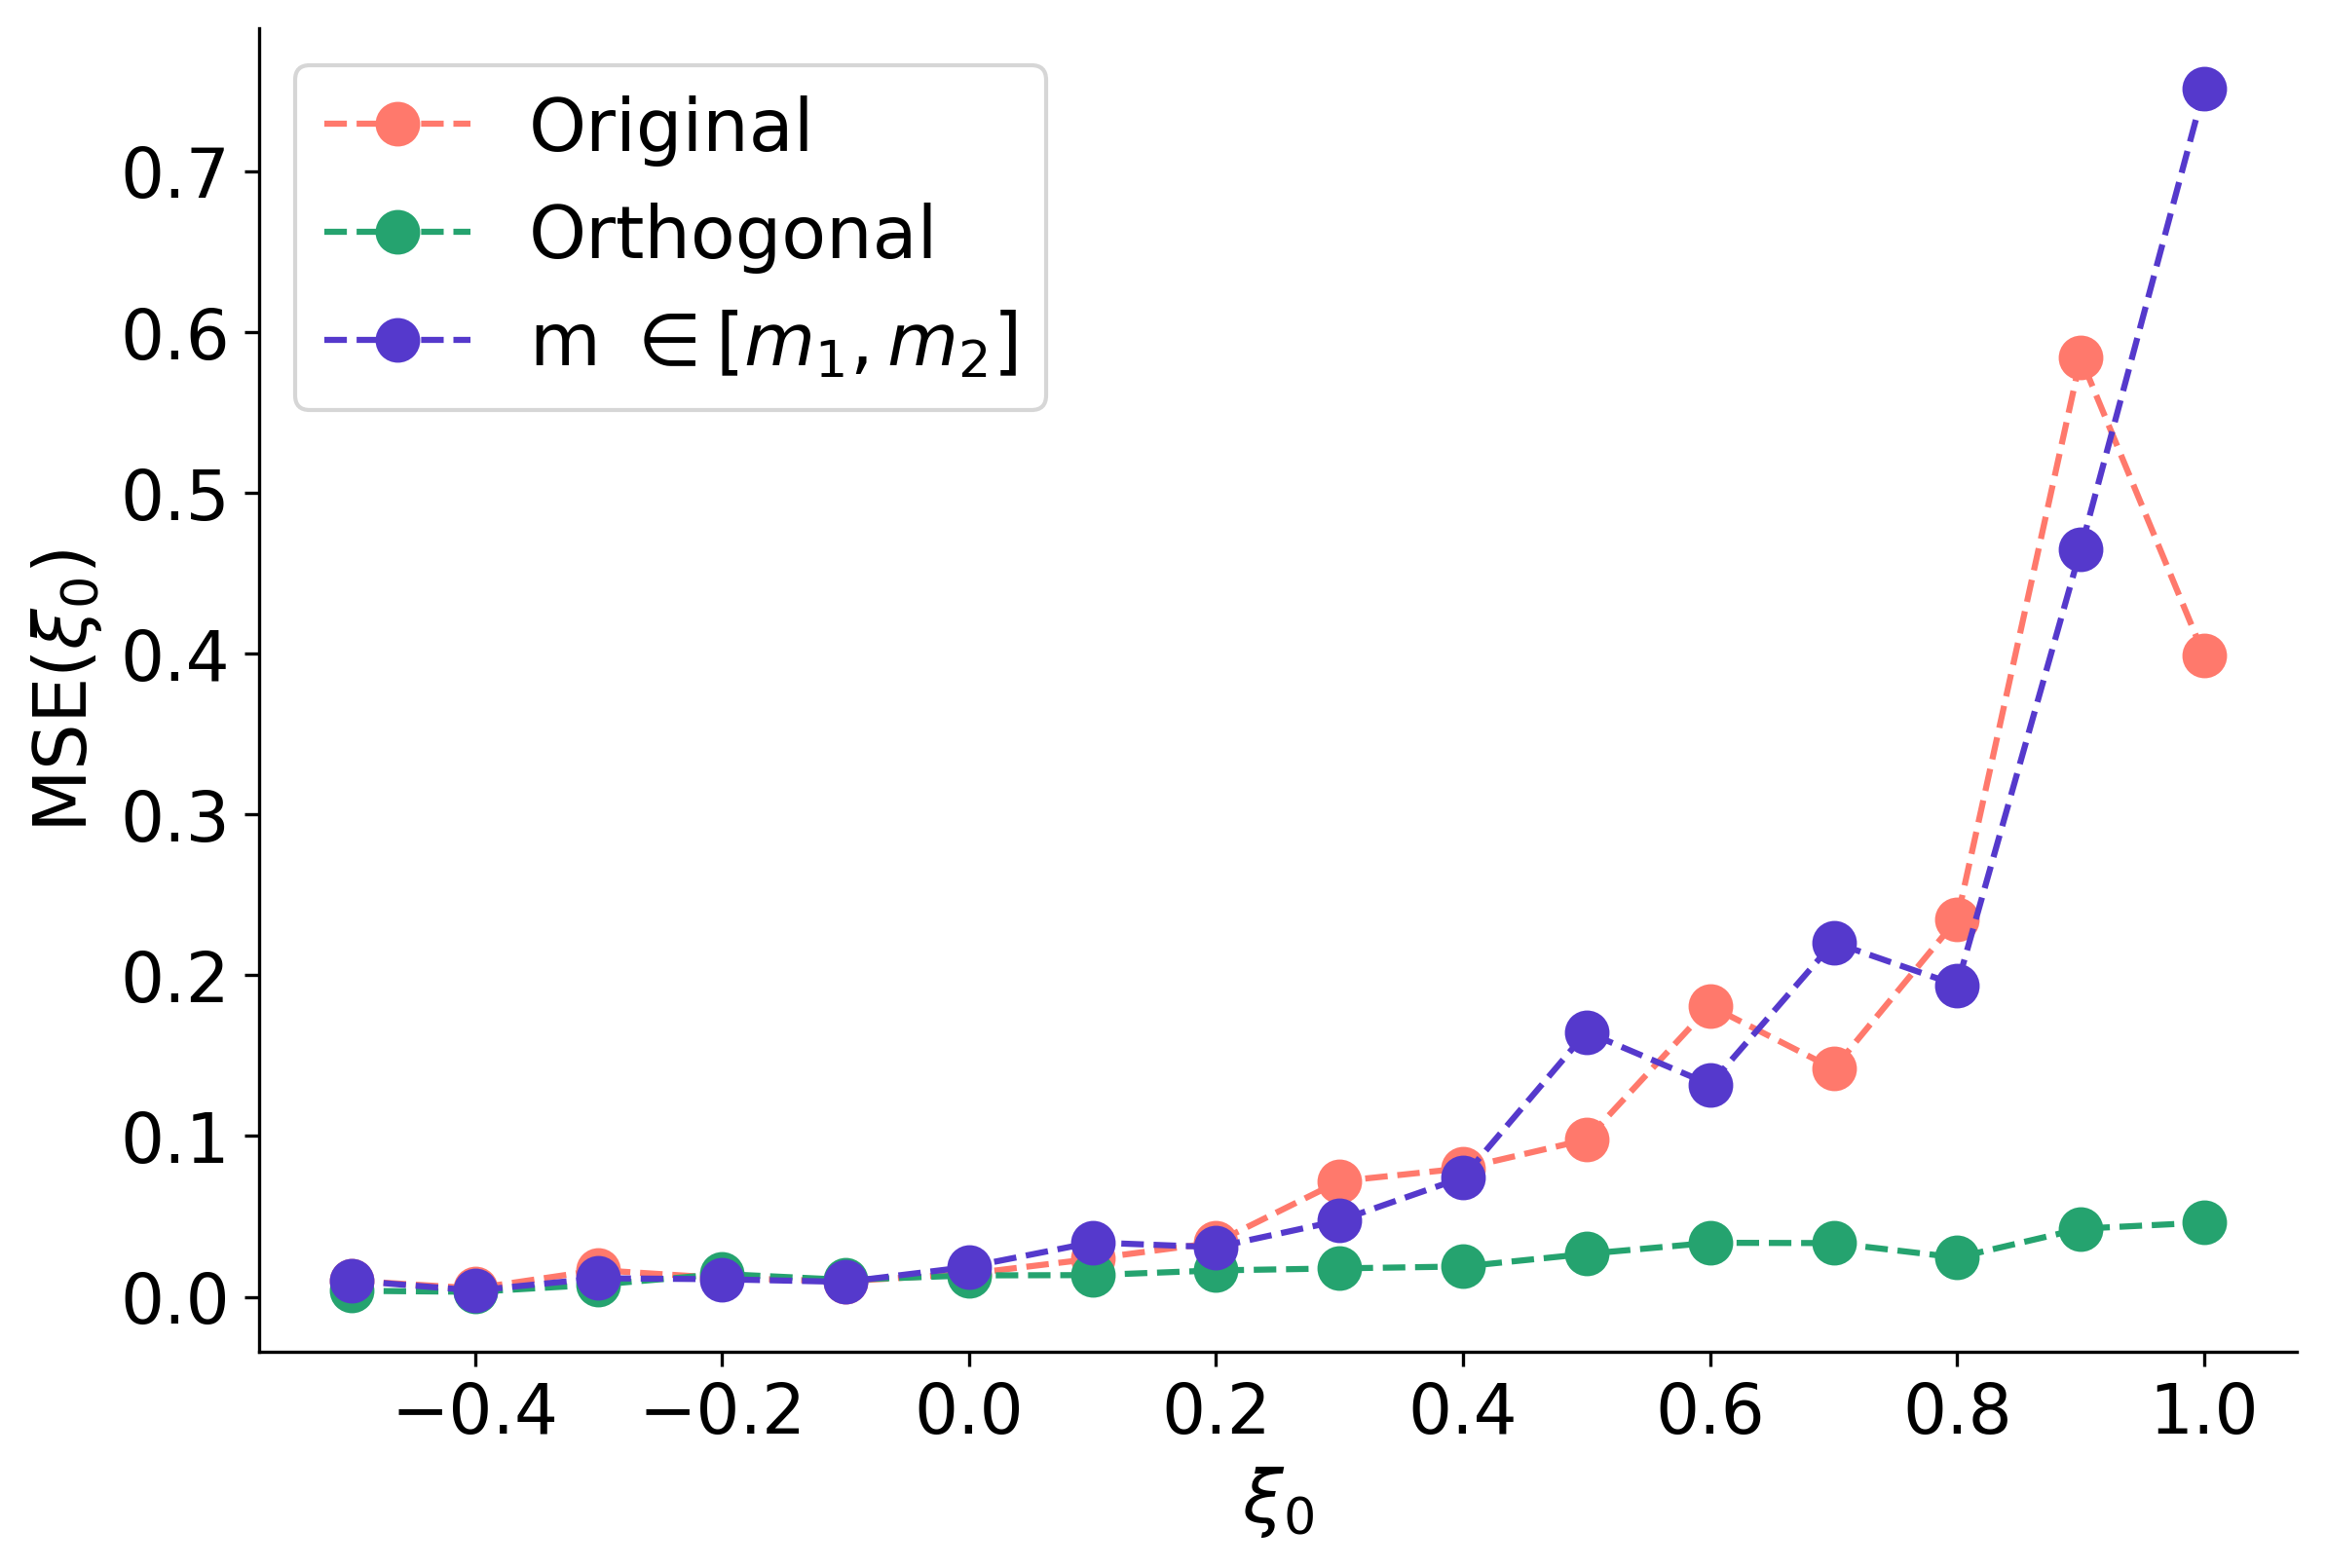

In [76]:
names = ["Original", "Orthogonal", "m $\in [m_1, m_2]$"]
# names = ["Jeffreys", "PC ($\lambda = 10$)", "MLE", "Original param."]
# names = ["MLE", "Jeffreys", "PC ($\lambda = 10$)"]


fig = plt.figure(figsize=(9,6), dpi = 300)
ax = fig.add_subplot(111)
# ax.set_yscale('log')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

for i, mse_l in enumerate(mse_array):
    plt.plot(xi_range, mse_l, ".--", color=COLOR_LIST2[i], 
             ms = 20, label = names[i])

#plt.grid(color = 'grey', which='both', linestyle = '--', linewidth = 0.5)
plt.xlabel("$\\xi_0$",  fontsize = 18)
plt.ylabel("MSE$(\\xi_0)$",  fontsize = 18)
plt.legend(fontsize = 18)
plt.show()


    - MSE élévé => exclusivement due à la variance
    - Faut-il inclure la param m=n ? La version avec n=500?
    - Séparer l'étude du prior et l'étude de la paramétrisation
   

#### 500 Points

In [ ]:
mse_array = []

folder = "mse/500_points/"
# mcmc_configs = ["Config2", "Config5", "mle", "Config1"]
mcmc_configs = ["Config2", "Config5", "mle"]


for config in (mcmc_configs):
    with open("data/{}xi_{}.csv".format(folder, config), "r") as f:
        reader = csv.reader(f, delimiter=',')
        xi_array = []
        for row in reader:
            xi_array.append(row)
        xi_array = np.transpose(np.asarray(xi_array))
        mse_list = []
        for i, xi_val in enumerate(xi_range):
            mse_list.append(np.mean([(float(x) - xi_val)**2 for x in xi_array[i]]))
        mse_array.append(mse_list)

In [ ]:
names = ["Jeffreys", "PC prior", "MLE", "Original param."]

fig = plt.figure(figsize=(9,6), dpi = 300)
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

for i, mse_l in enumerate(mse_array):
    plt.plot(xi_range, mse_l, ".--", color=COLOR_LIST[i], 
             ms = 20, label = names[i])

plt.grid(color = 'grey', which='both', linestyle = '--', linewidth = 0.5)
plt.xlabel("$\\xi$",  fontsize = 17)
plt.ylabel("MSE$(\\xi)$",  fontsize = 17)
# plt.legend(fontsize = 17)
plt.show()


#### Comparison of MLE with the sample size

In [ ]:
mse_array = []
mcmc_configs = ["100_points", "500_points"]
# xi_ranges = [np.linspace(-0.5, 1, 13), np.linspace(-0.5, 1, 16)]


for idx_config, config in enumerate(mcmc_configs):
    with open("data/mse/{}/xi_mle.csv".format(config), "r") as f:
        reader = csv.reader(f, delimiter=',')
        xi_array = []
        for row in reader:
            xi_array.append(row)
        xi_array = np.transpose(np.asarray(xi_array))
        mse_list = []
        for i, xi_val in enumerate(xi_range):
            mse_list.append(np.mean([(float(x) - xi_val)**2 for x in xi_array[i]]))
        mse_array.append(mse_list)

In [ ]:
names = ["MLE with n=100", "MLE with n=500"]

fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

for i, mse_l in enumerate(mse_array):
    plt.plot(xi_range, mse_l, ".--", color=COLOR_LIST[i], 
             ms = 20, label = names[i])

plt.grid(color = 'grey', which='both', linestyle = '--', linewidth = 0.5)
plt.xlabel("$\\xi$",  fontsize = 17)
plt.ylabel("MSE$(\\xi)$",  fontsize = 17)
plt.legend(fontsize = 17)
plt.show()


#### Ratio between the two MLE

In [ ]:
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

plt.plot(xi_range, [x/y for (x,y) in zip(mse_array[0], mse_array[1])], ".--", color=COLOR_LIST[i], 
             ms = 20)

plt.grid(color = 'grey', which='both', linestyle = '--', linewidth = 0.5)
plt.xlabel("$\\xi$",  fontsize = 17)
plt.ylabel("MSE ratio",  fontsize = 17)
plt.show()
